<a href="https://colab.research.google.com/github/DavisRayM/msft-stock-prediction/blob/main/msft-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Author: Davis Muro

For CPSC 5610

Microsoft Stock Prediction

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(25)
tf.random.set_seed(25)

In [3]:
df = pd.read_csv('data/MSFT.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800


## Preprocessing

In [4]:
# Convert `Date` to `DateTime`
df['Date'] = pd.to_datetime(df['Date'])

# Sort dataframe by `Date` (Ascending)
df.sort_values(by='Date', inplace=True, ascending=True)

# Drop Adj Close
df.drop(columns=['Adj Close'], inplace=True)

df.head(5)

,Date,Open,High,Low,Close,Volume
0,2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
1,2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2,2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
3,2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
4,2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Normalize numerical columns using MinMaxScaler
scaler = MinMaxScaler()
df[['Close', 'High', 'Low', 'Open', 'Volume']] = scaler.fit_transform(df[['Close', 'High', 'Low', 'Open', 'Volume']])

df.head(5)

,Date,Open,High,Low,Close,Volume
0,2016-11-07,0.005530,0.005148,0.009021,0.008264,0.233481
1,2016-11-08,0.008277,0.006078,0.010356,0.008444,0.149396
2,2016-11-09,0.006315,0.005398,0.006928,0.007366,0.406553
3,2016-11-10,0.008028,0.005041,0.001263,0.002084,0.485441
4,2016-11-11,0.000000,0.000143,0.002634,0.003234,0.301900


In [6]:
# Set `Date` as index; It's unique
if (df.duplicated(subset=['Date']).sum() > 0):
    assert False, "Duplicate dates found"

df.set_index('Date', inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,0.005530,0.005148,0.009021,0.008264,0.233481
2016-11-08,0.008277,0.006078,0.010356,0.008444,0.149396
2016-11-09,0.006315,0.005398,0.006928,0.007366,0.406553
2016-11-10,0.008028,0.005041,0.001263,0.002084,0.485441
2016-11-11,0.000000,0.000143,0.002634,0.003234,0.301900


In [7]:
df.shape

(1259, 5)

## Windowing

In [8]:
train_size = df.shape[0] * 80 // 100
test_size = df.shape[0] - train_size
train_size, test_size

(1007, 252)

In [9]:
# Use a sliding window of N days (e.g., 20 days) to predict the next dayʼs values.
train_data = tf.data.Dataset.from_tensor_slices(df.values[:train_size])
test_data = tf.data.Dataset.from_tensor_slices(df.values[train_size:])

n_steps = 20
window_length = n_steps + 1
train_data = train_data.window(window_length, shift =1, drop_remainder=True )
test_data = test_data.window(window_length, shift =1, drop_remainder=True )

In [10]:
for window in train_data.take(2):
    t = list(window.as_numpy_iterator())
    print(len(t))
    print(t)

21
[array([0.00553018, 0.00514818, 0.00902071, 0.00826387, 0.23348119]), array([0.00827743, 0.00607771, 0.01035579, 0.00844353, 0.14939629]), array([0.00631511, 0.00539844, 0.00692791, 0.00736562, 0.40655291]), array([0.00802769, 0.00504094, 0.00126291, 0.00208394, 0.48544114]), array([0.00000000e+00, 1.42994526e-04, 2.63404403e-03, 3.23369140e-03,
       3.01899987e-01]), array([0.00281861, 0.        , 0.        , 0.        , 0.32656466]), array([0.00035679, 0.0014658 , 0.00375262, 0.00269474, 0.27431574]), array([0.00253318, 0.00207357, 0.00552068, 0.00549728, 0.19175083]), array([0.00777794, 0.00668549, 0.00970629, 0.00905433, 0.23798818]), array([0.00909804, 0.00736476, 0.01089702, 0.00801236, 0.19515877]), array([0.00809904, 0.00675699, 0.01133001, 0.00984479, 0.11777511]), array([0.00981162, 0.00779377, 0.01273725, 0.01077896, 0.15200956]), array([0.00991865, 0.00722175, 0.01071661, 0.00819202, 0.13893071]), array([0.00738547, 0.00518393, 0.01028362, 0.0086591 , 0.00947826]), arr

In [11]:
for window in test_data.take(2):
    t = list(window.as_numpy_iterator())
    print(len(t))
    print(t)

21
[array([0.58523615, 0.5908977 , 0.58003172, 0.59499856, 0.17151705]), array([0.59301411, 0.60434017, 0.5794905 , 0.57584794, 0.35610332]), array([0.55754957, 0.56279716, 0.55004689, 0.54933168, 0.35273295]), array([0.55002138, 0.56830284, 0.55899542, 0.56923686, 0.21205878]), array([0.5672185 , 0.57212826, 0.56715018, 0.56524864, 0.13647445]), array([0.5641858 , 0.56608628, 0.56606768, 0.56909311, 0.10783931]), array([0.55886966, 0.56723034, 0.56736666, 0.57168006, 0.16883347]), array([0.56325817, 0.56701579, 0.56577901, 0.56172753, 0.16113527]), array([0.55451687, 0.55804223, 0.55441288, 0.54958322, 0.20177139]), array([0.54641787, 0.55039145, 0.5508046 , 0.55439781, 0.16728651]), array([0.54934348, 0.55132097, 0.5510572 , 0.54710405, 0.14850722]), array([0.54488366, 0.54774583, 0.54441797, 0.54609802, 0.17586703]), array([0.54003136, 0.55475312, 0.54694376, 0.55957172, 0.25577919]), array([0.55972597, 0.55847123, 0.55993361, 0.55960763, 0.13087804]), array([0.55879835, 0.5619749 ,

In [12]:
def show_dataset(dataset, n):
    dataset = dataset.prefetch(1)
    for tensor in dataset.take(n):
        print(tensor)
train_data = train_data.flat_map(lambda window: window.batch(window_length))
test_data = test_data.flat_map(lambda window: window.batch(window_length))

show_dataset(train_data, 2)

tf.Tensor(
[[5.53018034e-03 5.14818192e-03 9.02071110e-03 8.26386525e-03
  2.33481190e-01]
 [8.27743299e-03 6.07771248e-03 1.03557872e-02 8.44352535e-03
  1.49396291e-01]
 [6.31511323e-03 5.39844111e-03 6.92791334e-03 7.36561863e-03
  4.06552908e-01]
 [8.02768631e-03 5.04093513e-03 1.26290677e-03 2.08393933e-03
  4.85441139e-01]
 [0.00000000e+00 1.42994526e-04 2.63404403e-03 3.23369140e-03
  3.01899987e-01]
 [2.81860986e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.26564660e-01]
 [3.56793194e-04 1.46580383e-03 3.75261943e-03 2.69473984e-03
  2.74315740e-01]
 [2.53317745e-03 2.07356900e-03 5.52068241e-03 5.49728005e-03
  1.91750830e-01]
 [7.77793607e-03 6.68549195e-03 9.70629236e-03 9.05432586e-03
  2.37988181e-01]
 [9.09804092e-03 7.36475975e-03 1.08970190e-02 8.01235619e-03
  1.95158766e-01]
 [8.09904352e-03 6.75699458e-03 1.13300095e-02 9.84479006e-03
  1.17775113e-01]
 [9.81161660e-03 7.79377193e-03 1.27372513e-02 1.07789594e-02
  1.52009555e-01]
 [9.91864529e-03 7.22175092e-

In [13]:
batch_size = 32
train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)
show_dataset(train_data, 2)

tf.Tensor(
[[[5.53018034e-03 5.14818192e-03 9.02071110e-03 8.26386525e-03
   2.33481190e-01]
  [8.27743299e-03 6.07771248e-03 1.03557872e-02 8.44352535e-03
   1.49396291e-01]
  [6.31511323e-03 5.39844111e-03 6.92791334e-03 7.36561863e-03
   4.06552908e-01]
  ...
  [3.03268863e-03 1.39429763e-03 5.48459235e-03 4.06007828e-03
   1.74250721e-01]
  [5.24475863e-03 5.39844111e-03 8.22689574e-03 7.54527873e-03
   1.55342359e-01]
  [7.84929328e-03 4.93367046e-03 9.09287679e-03 6.57517239e-03
   1.20225590e-01]]

 [[8.27743299e-03 6.07771248e-03 1.03557872e-02 8.44352535e-03
   1.49396291e-01]
  [6.31511323e-03 5.39844111e-03 6.92791334e-03 7.36561863e-03
   4.06552908e-01]
  [8.02768631e-03 5.04093513e-03 1.26290677e-03 2.08393933e-03
   4.85441139e-01]
  ...
  [5.24475863e-03 5.39844111e-03 8.22689574e-03 7.54527873e-03
   1.55342359e-01]
  [7.84929328e-03 4.93367046e-03 9.09287679e-03 6.57517239e-03
   1.20225590e-01]
  [6.35078470e-03 8.22279841e-03 9.09287679e-03 1.16772060e-02
   2.25237

In [14]:
train_data = train_data.map(lambda window: (window[:, :-1, :], window[:, -1, :]))
test_data = test_data.map(lambda window: (window[:, :-1, :], window[:, -1, :]))
show_dataset(train_data, 2)

(<tf.Tensor: shape=(32, 20, 5), dtype=float64, numpy=
array([[[5.53018034e-03, 5.14818192e-03, 9.02071110e-03, 8.26386525e-03,
         2.33481190e-01],
        [8.27743299e-03, 6.07771248e-03, 1.03557872e-02, 8.44352535e-03,
         1.49396291e-01],
        [6.31511323e-03, 5.39844111e-03, 6.92791334e-03, 7.36561863e-03,
         4.06552908e-01],
        ...,
        [6.70758146e-03, 3.82539049e-03, 5.98975217e-03, 3.88043255e-03,
         2.61196438e-01],
        [3.03268863e-03, 1.39429763e-03, 5.48459235e-03, 4.06007828e-03,
         1.74250721e-01],
        [5.24475863e-03, 5.39844111e-03, 8.22689574e-03, 7.54527873e-03,
         1.55342359e-01]],

       [[8.27743299e-03, 6.07771248e-03, 1.03557872e-02, 8.44352535e-03,
         1.49396291e-01],
        [6.31511323e-03, 5.39844111e-03, 6.92791334e-03, 7.36561863e-03,
         4.06552908e-01],
        [8.02768631e-03, 5.04093513e-03, 1.26290677e-03, 2.08393933e-03,
         4.85441139e-01],
        ...,
        [3.03268863e-03, 1.

In [15]:
# Shape your input as (samples, timesteps, features) .
train_data = train_data.prefetch(1)
for X_batch, Y_batch in train_data.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 20, 5) (32, 5)


In [16]:
test_data = test_data.prefetch(1)
for X_batch, Y_batch in test_data.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 20, 5) (32, 5)


## Modelling

In [17]:
from tensorflow.keras.layers import BatchNormalization, Layer
from tensorflow.keras import activations

class BatchNormSimpleRNN(Layer):
    def __init__(self, units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, **kwargs):
        super().__init__(**kwargs)
        self.simple_rnn = SimpleRNN(units, activation=None, return_sequences=return_sequences, **kwargs)
        self.batch_norm = BatchNormalization()
        self.activation = activations.tanh  # or any other activation you want

    def call(self, inputs, training=None):
        x = self.simple_rnn(inputs)
        x = self.batch_norm(x, training=training)
        x = self.activation(x)
        return x

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Input
from typing import Tuple, List

def create_model(kind: str = "simple", input_shape: Tuple[int, int, int] = (n_steps, 5), hidden_units: List = [128, 64]):
  model = tf.keras.models.Sequential()
  model.add(Input(shape=input_shape))

  if kind == "simple":
    model.add(BatchNormSimpleRNN(hidden_units[0], return_sequences=(len(hidden_units) > 1), dropout=0.2, recurrent_dropout=0.2))

    for units in hidden_units[1:-1]:
      model.add(BatchNormSimpleRNN(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

    if len(hidden_units) > 1:
      model.add(BatchNormSimpleRNN(hidden_units[-1], return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "lstm":
    model.add(LSTM(hidden_units[0], return_sequences=(len(hidden_units) > 1), dropout=0.2, recurrent_dropout=0.2))

    for units in hidden_units[1:-1]:
      model.add(LSTM(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

    if len(hidden_units) > 1:
      model.add(LSTM(hidden_units[-1], return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "gru":
    model.add(GRU(hidden_units[0], return_sequences=(len(hidden_units) > 1), dropout=0.2, recurrent_dropout=0.2))

    for units in hidden_units[1:-1]:
      model.add(GRU(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

    if len(hidden_units) > 1:
      model.add(GRU(hidden_units[-1], return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  else:
    assert False, "Unsupported kind: " + kind

  model.add(Dense(input_shape[1]))
  model.compile(loss="mse", optimizer="adam", metrics=["mae"])
  return model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=3,
    restore_best_weights=True
)

epochs = 20

### Simple RNN

Uses SimpleRNN + Batch normalization layers with 1 hidden layer.

In [20]:
simple = create_model(kind="simple", hidden_units=[128, 64])
simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_norm_simple_rnn           │ (None, 20, 128)        │        17,664 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_simple_rnn_1         │ (None, 64)             │        12,608 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,597 (119.52 KB)

 Trainable params: 30,213 (118.02 KB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
simple.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/20
     30/Unknown 7s 18ms/step - loss: 0.2383 - mae: 0.3644

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2329 - mae: 0.3607 - val_loss: 0.5404 - val_mae: 0.6141
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0327 - mae: 0.1391 - val_loss: 0.4147 - val_mae: 0.5678
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0263 - mae: 0.1307 - val_loss: 0.3484 - val_mae: 0.5437
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0254 - mae: 0.1311 - val_loss: 0.3648 - val_mae: 0.5510
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0263 - mae: 0.1363 - val_loss: 0.3650 - val_mae: 0.5448
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0255 - mae: 0.1333 - val_loss: 0.3885 - val_mae: 0.5724


In [22]:
result = pd.DataFrame(simple.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.152185,0.305324,0.540413,0.614126
1,0.046571,0.167205,0.414683,0.567770
2,0.035210,0.147287,0.348378,0.543666
3,0.031915,0.141584,0.364837,0.550980
4,0.031487,0.142265,0.365047,0.544815


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

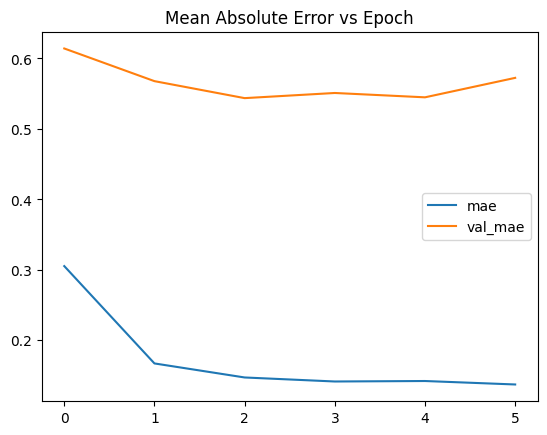

In [23]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

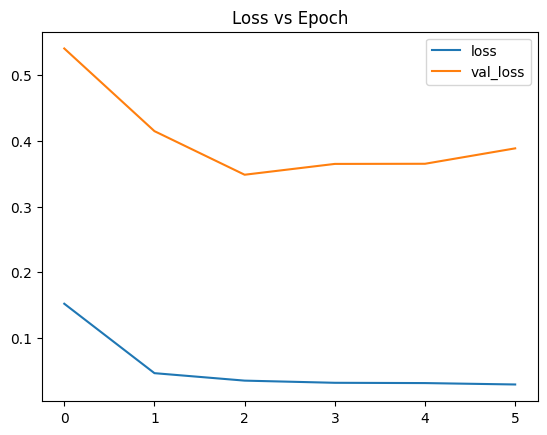

In [24]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### GRU Model

Uses a GRU layer with one hidden layer.

In [25]:
gru = create_model(kind="gru", hidden_units=[128, 64])
gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 128)        │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,413 (349.27 KB)

 Trainable params: 89,413 (349.27 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
gru.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/20
     31/Unknown 10s 102ms/step - loss: 0.0046 - mae: 0.0447

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - loss: 0.0047 - mae: 0.0451 - val_loss: 0.0191 - val_mae: 0.1117
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0145 - mae: 0.1005 - val_loss: 0.0160 - val_mae: 0.1120
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0086 - mae: 0.0748 - val_loss: 0.0070 - val_mae: 0.0720
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0054 - mae: 0.0589 - val_loss: 0.0047 - val_mae: 0.0521
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0059 - mae: 0.0630 - val_loss: 0.0087 - val_mae: 0.0783
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0046 - mae: 0.0541 - val_loss: 0.0103 - val_mae: 0.0871
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0057 - mae: 0.0614 - val_loss: 0.0087 - val_mae: 0.0773


In [27]:
result = pd.DataFrame(gru.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.007615,0.057718,0.019077,0.111738
1,0.011707,0.086503,0.015970,0.111979
2,0.008665,0.070627,0.006982,0.072018
3,0.007466,0.064159,0.004681,0.052101
4,0.007283,0.064086,0.008743,0.078297


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

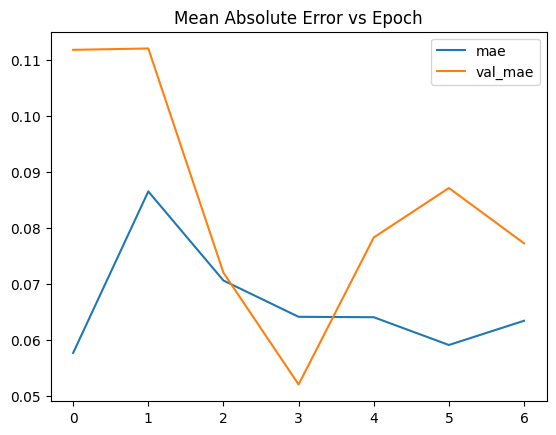

In [28]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

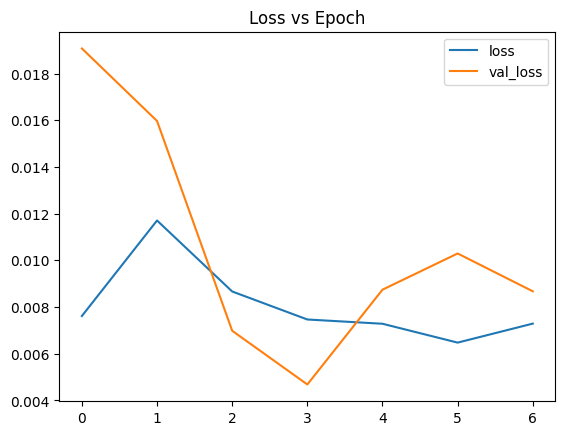

In [29]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### LSTM

Uses LSTM layers with 1 hidden layer.

In [30]:
lstm = create_model(kind="lstm", hidden_units=[128, 64])
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,341 (462.27 KB)

 Trainable params: 118,341 (462.27 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
lstm.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/20
     31/Unknown 13s 64ms/step - loss: 0.0048 - mae: 0.0447

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - loss: 0.0049 - mae: 0.0452 - val_loss: 0.0250 - val_mae: 0.1315
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0134 - mae: 0.0958 - val_loss: 0.0190 - val_mae: 0.1157
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0110 - mae: 0.0839 - val_loss: 0.0132 - val_mae: 0.0926
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0079 - mae: 0.0745 - val_loss: 0.0189 - val_mae: 0.1126
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0079 - mae: 0.0717 - val_loss: 0.0131 - val_mae: 0.0926
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0077 - mae: 0.0725 - val_loss: 0.0104 - val_mae: 0.0814
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0050 - mae: 0.0522 - val_loss: 0.0104 - val_mae: 0.0812
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0062 - mae: 0.0549 - val_loss: 0.0065 - val_mae: 0.0628
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0050 - mae: 

In [32]:
result = pd.DataFrame(lstm.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.007576,0.058473,0.024960,0.131549
1,0.010716,0.083123,0.018951,0.115679
2,0.009676,0.074067,0.013233,0.092643
3,0.008570,0.069792,0.018910,0.112622
4,0.009935,0.077338,0.013067,0.092633


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

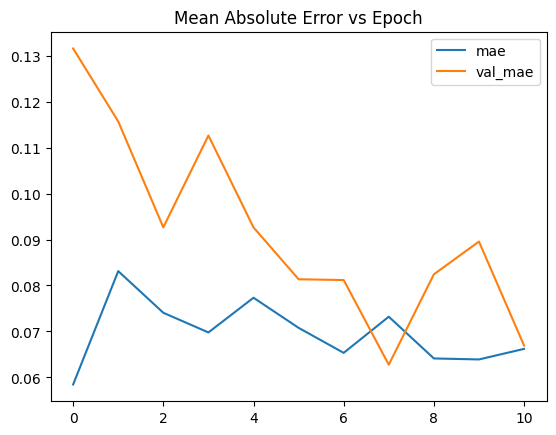

In [33]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

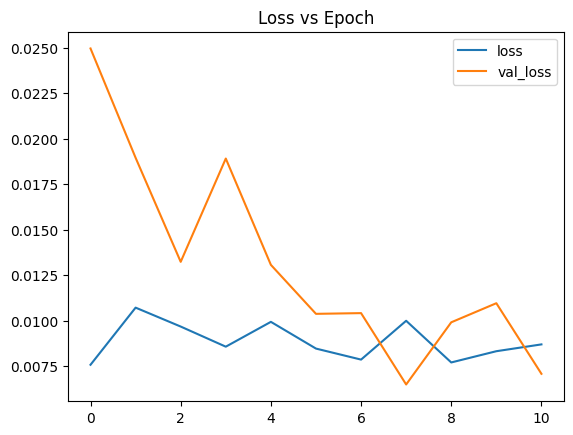

In [34]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

## Evaluation

In [35]:
from pandas.tseries.offsets import BDay

# Number of time steps your model expects (e.g., 20)
n_steps = 20

# Define prediction start date (must be inside your df date range)
predict_start = pd.Timestamp('2021-10-25')

# Calculate prediction end date as 9 business days after predict_start
predict_end = predict_start + BDay(9)  # 10 business days total including start

# Get the next 10 business days (dates) from predict_start in your df index
predict_dates = df.loc[predict_start:].index[:10]

# Extract true values for those prediction dates
true_values = df.loc[predict_dates].values

# Input window starts n_steps business days before predict_start
input_start = predict_start - BDay(n_steps)

# Select input window data (20 business days before predict_start)
input_window = df.loc[input_start : predict_start - BDay(1)].values

# Scale the input window using your fitted scaler
input_scaled = scaler.transform(input_window)

# Reshape for model input: (batch=1, time_steps=n_steps, features=5)
input_seq = input_scaled[np.newaxis, :, :]

# Confirm shapes and dates
print(f"Input window shape: {input_seq.shape}")      # Expect (1, 20, 5)
print(f"True values shape: {true_values.shape}")     # Expect (10, 5)
print(f"Prediction dates:\n{predict_dates}")

Input window shape: (1, 20, 5)
True values shape: (10, 5)
Prediction dates:
DatetimeIndex(['2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28',
               '2021-10-29', '2021-11-01', '2021-11-02', '2021-11-03',
               '2021-11-04', '2021-11-05'],
              dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [36]:
predictions_scaled = []
model = simple

for day in range(10):
  pred_scaled = model.predict(input_seq)
  print(f"Day {day} - pred_scaled shape: {pred_scaled.shape}")  # Should be (1, 5)
  predictions_scaled.append(pred_scaled[0])
  input_seq = np.concatenate([input_seq[:, 1:, :], pred_scaled[:, np.newaxis, :]], axis=1)
  print(f"Day {day} - input_seq shape after update: {input_seq.shape}")  # Should be (1, 20, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Day 0 - pred_scaled shape: (1, 5)
Day 0 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 1 - pred_scaled shape: (1, 5)
Day 1 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 2 - pred_scaled shape: (1, 5)
Day 2 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Day 3 - pred_scaled shape: (1, 5)
Day 3 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 4 - pred_scaled shape: (1, 5)
Day 4 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 5 - pred_scaled shape: (1, 5)
Day 5 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Day 6 - pred_scaled shape: (1, 5)
Day 6 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Day 7 - pred_scaled shape: (1, 5)
Day 7 - input_seq shape after update: (1, 20, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43m

In [37]:
# Predict all 5 columns for the 10 business days between 11/08/2021 and 11/19/2021.
print("DataFrame date range:", df.index.min(), "to", df.index.max())
print("predict_start:", predict_start)
print("predict_end:", predict_end)

DataFrame date range: 2016-11-07 00:00:00 to 2021-11-05 00:00:00
predict_start: 2021-10-25 00:00:00
predict_end: 2021-11-05 00:00:00


In [38]:
print(predict_start in df.index)
print(predict_end in df.index)

True
True


In [39]:
predictions_scaled = np.array(predictions_scaled)  # shape (num_days, 5)
predictions = scaler.inverse_transform(predictions_scaled)

print("true_values shape:", true_values.shape)
print("predictions shape:", predictions.shape)

true_values shape: (10, 5)
predictions shape: (10, 5)


Open: MSE=664.5140, MAE=23.3696
High: MSE=1919.7005, MAE=43.0822
Low: MSE=23891.4211, MAE=152.3169
Close: MSE=21933.0468, MAE=146.2601
Volume: MSE=5211961438021924.0000, MAE=72055585.8009


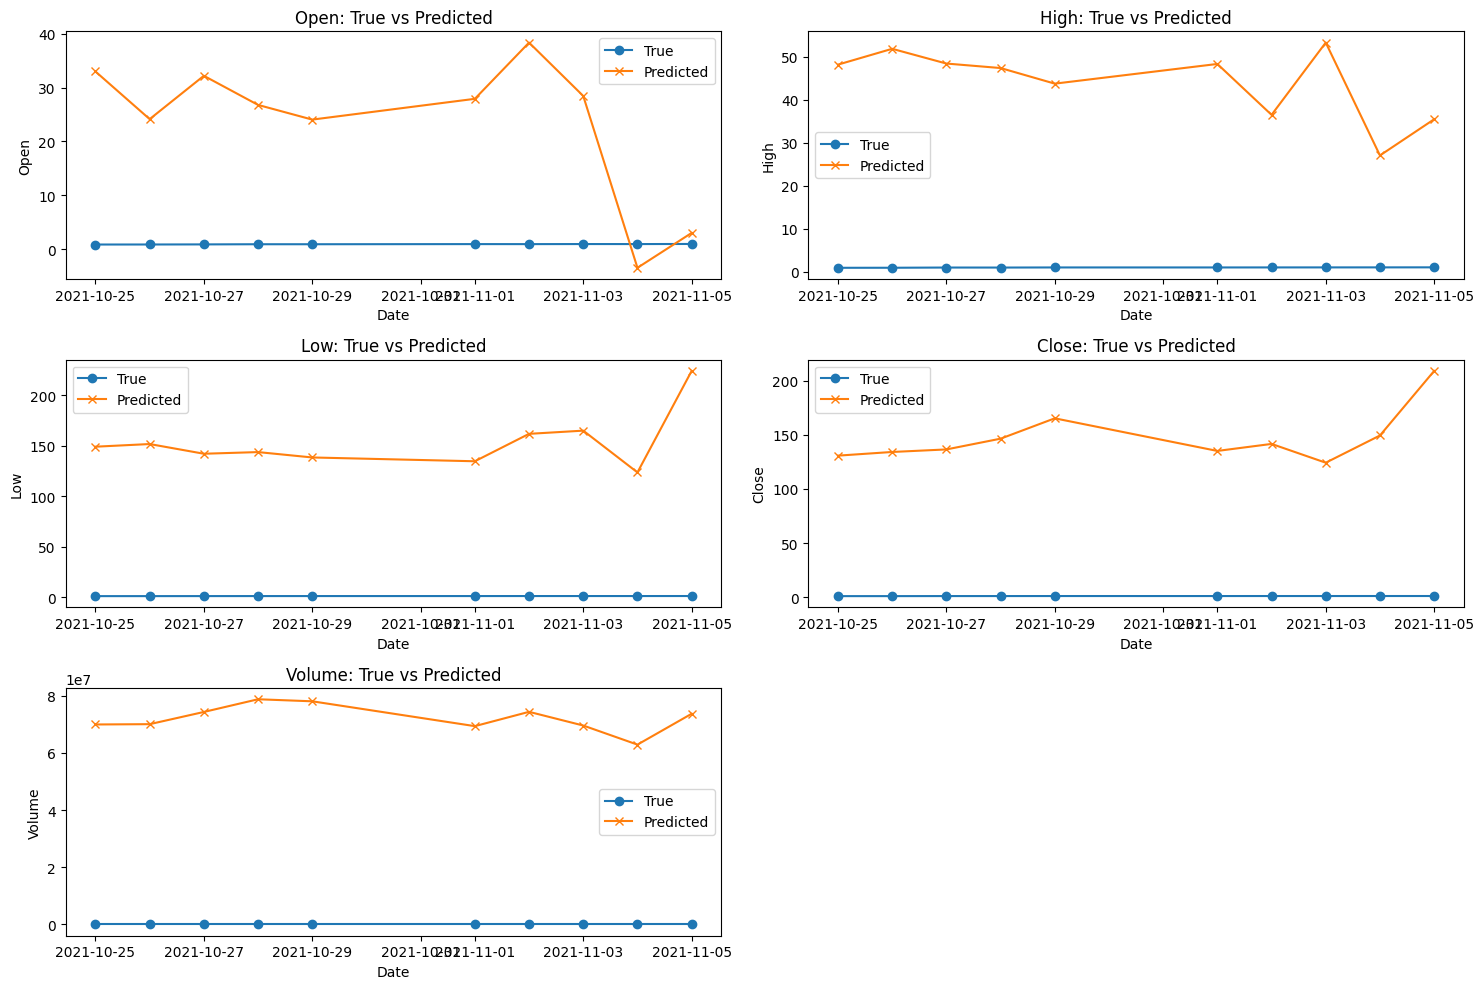

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

feature_names = df.columns.tolist()
dates = df.loc[predict_start : predict_end].index

for i, feature in enumerate(feature_names):
    mse = mean_squared_error(true_values[:, i], predictions[:, i])
    mae = mean_absolute_error(true_values[:, i], predictions[:, i])
    print(f"{feature}: MSE={mse:.4f}, MAE={mae:.4f}")

plt.figure(figsize=(15, 10))

for i, feature in enumerate(feature_names):
    plt.subplot(3, 2, i+1)
    plt.plot(dates, true_values[:, i], label='True', marker='o')
    plt.plot(dates, predictions[:, i], label='Predicted', marker='x')
    plt.title(f"{feature}: True vs Predicted")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()

In [47]:
import os
print(os.listdir("/content"))
!jupyter nbconvert --to html /content/msft-prediction.ipynb --output msft-prediction.html

from google.colab import files

['.config', '.ipynb_checkpoints', 'data', 'sample_data']
[NbConvertApp] WARNING | pattern '/content/msft-prediction.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prom